In [60]:
import os
import json
import numpy as np
import glob
from numpy.fft import rfft
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
SAMPLE_RATE = 50  # Hz
TRAINING_WINDOW_MS = 1640  # in milliseconds
TRAINING_WINDOW_SAMPLES = int(TRAINING_WINDOW_MS / 1000 * SAMPLE_RATE)  
FFT_LENGTH = 16
FFT_STRIDE = FFT_LENGTH // 2  # 50% overlap → 8 samples

In [51]:
def extract_spectral_features_from_window(window, fft_length=FFT_LENGTH, fft_stride=FFT_STRIDE):
    n_samples = len(window)
    frames = []
    for start in range(0, n_samples - fft_length + 1, fft_stride):
        frame = window[start:start+fft_length]
        # Apply Hamming window
        frame = frame * np.hamming(fft_length)
        # Compute FFT (rfft returns fft_length//2 + 1 values)
        fft_vals = rfft(frame, n=fft_length)
        # Magnitude spectrum
        mag = np.abs(fft_vals)
        # Apply log10; add a small epsilon to avoid log(0)
        log_mag = np.log10(mag + 1e-8)
        # Exclude DC component (first bin)
        frames.append(log_mag[1:])
    if len(frames) == 0:
        return None
    frames = np.array(frames)  # shape: (num_frames, 8)
    # Aggregate: for each frequency bin take the maximum value across frames
    feature_vector = np.max(frames, axis=0)
    return feature_vector

In [52]:
def segment_training_windows(signal, window_size=TRAINING_WINDOW_SAMPLES, stride=TRAINING_WINDOW_SAMPLES):
 
    segments = []
    n_samples = len(signal)
    for start in range(0, n_samples - window_size + 1, stride):
        segments.append(signal[start:start+window_size])
    return segments

In [53]:
def determine_label_from_filename(filename):
    fname = filename.lower()
    if "idle" in fname:
        return "idle"
    elif "terrestrial" in fname:
        return "terrestrial"
    elif "vertical" in fname:
        return "vertical"
    elif "martime" in fname:
        return "martime"
    else:
        return "unknown"


In [54]:
def process_file(filepath, window_size=100, step_size=10):
    with open(filepath, 'r') as f:
        data = json.load(f)
    values = data.get("payload", {}).get("values", None)
    if values is None:
        return None
    values = np.array(values)  # shape: (n_samples, n_channels)
    
    channel_features_list = []
    # Process each channel independently
    for ch in range(values.shape[1]):
        ch_signal = values[:, ch]
        # Segment the signal into non-overlapping training windows
        segments = segment_training_windows(ch_signal, window_size=TRAINING_WINDOW_SAMPLES, stride=TRAINING_WINDOW_SAMPLES)
        ch_features = []
        for seg in segments:
            feats = extract_spectral_features_from_window(seg, fft_length=FFT_LENGTH, fft_stride=FFT_STRIDE)
            if feats is not None:
                ch_features.append(feats)
        if len(ch_features) > 0:
            # Shape: (num_segments, 8)
            channel_features_list.append(np.array(ch_features))
        else:
            channel_features_list.append(np.empty((0, FFT_LENGTH//2)))
    
    # Ensure that all channels yield the same number of segments
    num_segments = min(feats.shape[0] for feats in channel_features_list if feats.shape[0] > 0)
    if num_segments == 0:
        return None
    # Truncate each channel's features to have the same number of segments
    truncated = [feats[:num_segments, :] for feats in channel_features_list]
    # Concatenate features across channels along the feature dimension (axis=1)
    features = np.hstack(truncated)
    return features

Total training segments: 48
Feature dimension per segment: 24


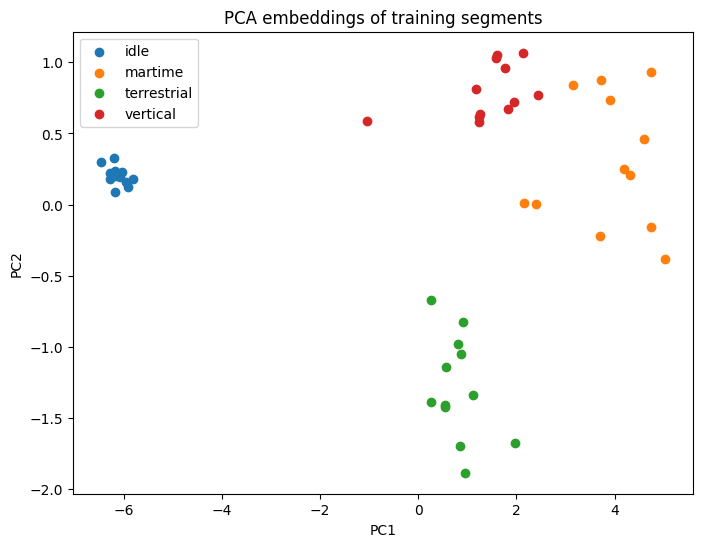

Class 'vertical': 12 segments
Saved embeddings for class 'vertical' to embeddings_vertical.csv
Class 'terrestrial': 12 segments
Saved embeddings for class 'terrestrial' to embeddings_terrestrial.csv
Class 'martime': 12 segments
Saved embeddings for class 'martime' to embeddings_martime.csv
Class 'idle': 12 segments
Saved embeddings for class 'idle' to embeddings_idle.csv


In [57]:
folder = "testing"  # update path as needed
filepaths = glob.glob(os.path.join(folder, "*.json"))

all_features = []
all_labels = []

# Process each file and extract features from each training window segment
for filepath in filepaths:
    feats = process_file(filepath)
    if feats is not None and feats.shape[0] > 0:
        label = determine_label_from_filename(os.path.basename(filepath))
        # For each training window (segment), add its feature vector and label
        for i in range(feats.shape[0]):
            all_features.append(feats[i])
            all_labels.append(label)

all_features = np.array(all_features)
print("Total training segments:", all_features.shape[0])
print("Feature dimension per segment:", all_features.shape[1])

# Apply PCA to reduce the dimensionality (e.g., to 2 components)
pca = PCA(n_components=2)
embeddings = pca.fit_transform(all_features)

# Plot embeddings
plt.figure(figsize=(8, 6))
for label in np.unique(all_labels):
    mask = np.array(all_labels) == label
    plt.scatter(embeddings[mask, 0], embeddings[mask, 1], label=label)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA embeddings of training segments")
plt.show()

# Group embeddings by class
embeddings_by_class = {}
for emb, label in zip(embeddings, all_labels):
    embeddings_by_class.setdefault(label, []).append(emb)

# Save embeddings for each class in separate CSV files
for label, emb_list in embeddings_by_class.items():
    emb_array = np.array(emb_list)
    print(f"Class '{label}': {emb_array.shape[0]} segments")
    df = pd.DataFrame(emb_array, columns=["PC1", "PC2"])
    df.to_csv(f"embeddings_{label}.csv", index=False)
    print(f"Saved embeddings for class '{label}' to embeddings_{label}.csv")



In [ ]:
train_files = ["embeddings_idle.csv", "embeddings_martime.csv", "embeddings_terrestrial.csv", "embeddings_vertical.csv"]
dfs_train = []
for f in train_files:
    df = pd.read_csv(os.path.join("training_embeddings", f))
    df["label"] = f.split("_")[1].split(".")[0]
    dfs_train.append(df)
train_df = pd.concat(dfs_train, ignore_index=True)

test_files = ["embeddings_idle.csv", "embeddings_martime.csv", "embeddings_terrestrial.csv", "embeddings_vertical.csv"]
dfs_test = []
for f in test_files:
    df = pd.read_csv(os.path.join("testing_embeddings", f))
    df["label"] = f.split("_")[1].split(".")[0]
    dfs_test.append(df)
test_df = pd.concat(dfs_test, ignore_index=True)

le = LabelEncoder()
train_df["label_enc"] = le.fit_transform(train_df["label"])
test_df["label_enc"] = le.transform(test_df["label"])

features = [col for col in train_df.columns if col not in ["label", "label_enc"]]
X_train = train_df[features].values
y_train = train_df["label_enc"].values
X_test = test_df[features].values
y_test = test_df["label_enc"].values

model = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=1000, multi_class="multinomial")
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))

test_df["predicted_enc"] = preds
test_df["predicted"] = le.inverse_transform(preds)
misclassified = test_df[test_df["predicted_enc"] != test_df["label_enc"]]
misclassified.to_csv("misclassifications.csv", index=False)
print("Misclassified samples saved to misclassifications.csv")

Accuracy: 0.9791666666666666


/home/sebastian/projects/AI-Agents/testing/test/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


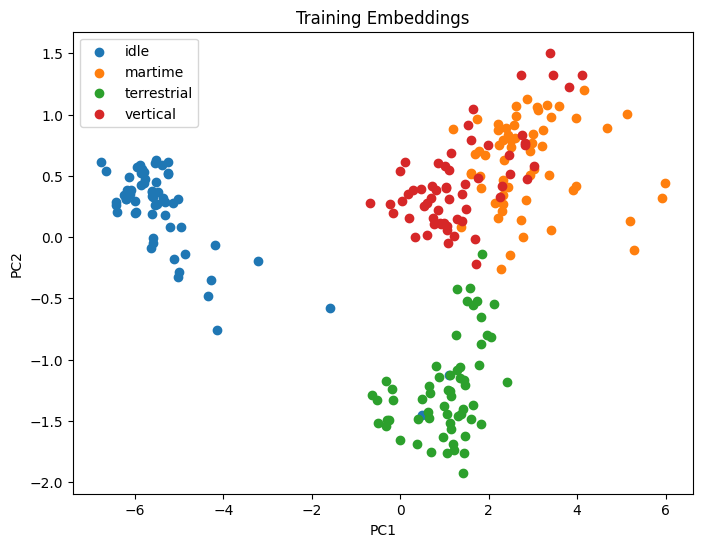

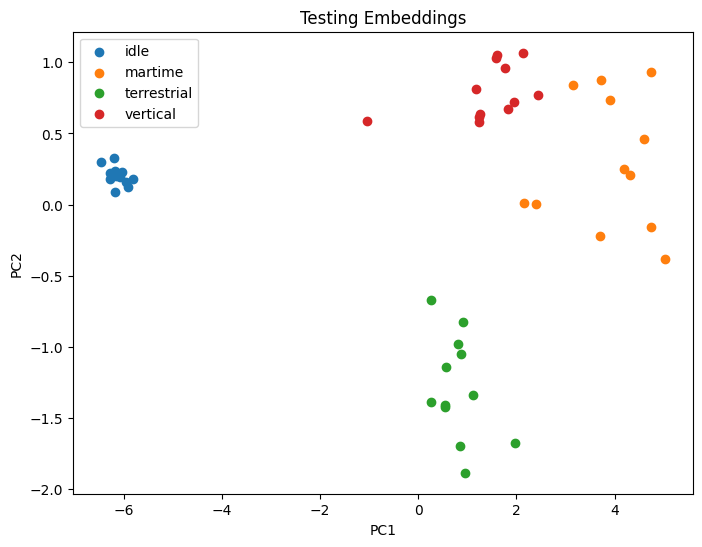

In [63]:
dfs = []
for f in ["embeddings_idle.csv", "embeddings_martime.csv", "embeddings_terrestrial.csv", "embeddings_vertical.csv"]:
    df = pd.read_csv(os.path.join("training_embeddings", f))
    df["label"] = f.split("_")[1].split(".")[0]
    dfs.append(df)
all_df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(8,6))
for lab in all_df["label"].unique():
    subset = all_df[all_df["label"]==lab]
    plt.scatter(subset["PC1"], subset["PC2"], label=lab)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Training Embeddings")
plt.legend()
plt.show()

dfs = []
for f in ["embeddings_idle.csv", "embeddings_martime.csv", "embeddings_terrestrial.csv", "embeddings_vertical.csv"]:
    df = pd.read_csv(os.path.join("testing_embeddings", f))
    df["label"] = f.split("_")[1].split(".")[0]
    dfs.append(df)
all_df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(8,6))
for lab in all_df["label"].unique():
    subset = all_df[all_df["label"]==lab]
    plt.scatter(subset["PC1"], subset["PC2"], label=lab)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Testing Embeddings")
plt.legend()
plt.show()


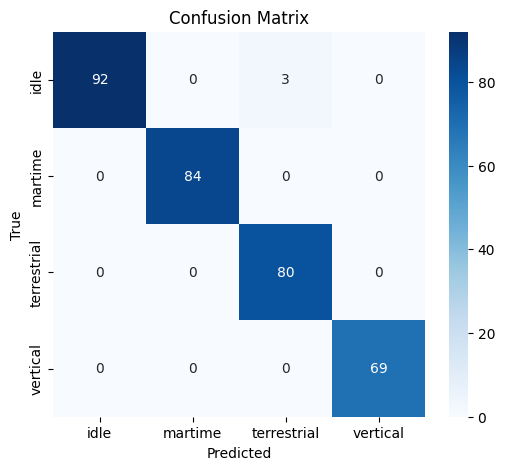

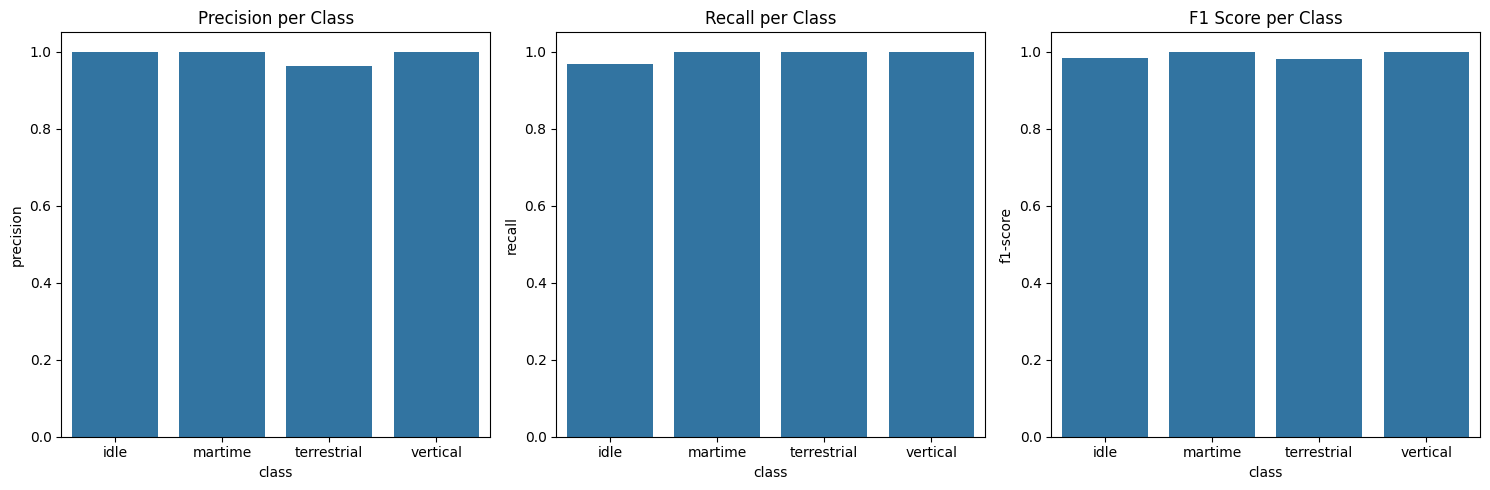

In [65]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# JSON data (as a multiline string)
json_data = r'''{
  "version":6,
  "validation": {
    "int8": {
      "confusion_matrix": [[92, 0, 3, 0], [0, 84, 0, 0], [0, 0, 80, 0], [0, 0, 0, 69]],
      "classification_report": {
        "0": {"precision": 1, "recall": 0.968421052631579, "f1-score": 0.983957219251337, "support": 95},
        "1": {"precision": 1, "recall": 1, "f1-score": 1, "support": 84},
        "2": {"precision": 0.963855421686747, "recall": 1, "f1-score": 0.9815950920245399, "support": 80},
        "3": {"precision": 1, "recall": 1, "f1-score": 1, "support": 69},
        "accuracy": 0.9908536585365854,
        "macro avg": {"precision": 0.9909638554216867, "recall": 0.9921052631578947, "f1-score": 0.9913880778189692, "support": 328},
        "weighted avg": {"precision": 0.9911842491918895, "recall": 0.9908536585365854, "f1-score": 0.9908644609476835, "support": 328}
      },
      "roc_auc": 0.9999887056697538,
      "loss": 0.03753776390940283,
      "support": 328,
      "weighted_average": {"precision": 0.9911842491918895, "recall": 0.9908536585365854, "f1-score": 0.9908644609476835},
      "class_names": ["idle", "martime", "terrestrial", "vertical"]
    },
    "float32": {
      "confusion_matrix": [[92, 0, 3, 0], [0, 84, 0, 0], [0, 0, 80, 0], [0, 0, 0, 69]],
      "classification_report": {
        "0": {"precision": 1, "recall": 0.968421052631579, "f1-score": 0.983957219251337, "support": 95},
        "1": {"precision": 1, "recall": 1, "f1-score": 1, "support": 84},
        "2": {"precision": 0.963855421686747, "recall": 1, "f1-score": 0.9815950920245399, "support": 80},
        "3": {"precision": 1, "recall": 1, "f1-score": 1, "support": 69},
        "accuracy": 0.9908536585365854,
        "macro avg": {"precision": 0.9909638554216867, "recall": 0.9921052631578947, "f1-score": 0.9913880778189692, "support": 328},
        "weighted avg": {"precision": 0.9911842491918895, "recall": 0.9908536585365854, "f1-score": 0.9908644609476835, "support": 328}
      },
      "roc_auc": 0.9999774113395076,
      "loss": 0.03816820617875346,
      "support": 328,
      "weighted_average": {"precision": 0.9911842491918895, "recall": 0.9908536585365854, "f1-score": 0.9908644609476835},
      "class_names": ["idle", "martime", "terrestrial", "vertical"]
    }
  }
}'''

# Load the JSON data
data = json.loads(json_data)
results = data["validation"]["int8"]
cm = np.array(results["confusion_matrix"])
class_names = results["class_names"]

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Prepare classification metrics for per-class plot
report = results["classification_report"]
metrics = []
for key in ["0", "1", "2", "3"]:
    entry = report[key]
    entry["class"] = class_names[int(key)]
    metrics.append(entry)
df_metrics = pd.DataFrame(metrics)

# Plot precision, recall, and f1-score per class
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x="class", y="precision", data=df_metrics, ax=axes[0])
axes[0].set_title("Precision per Class")
sns.barplot(x="class", y="recall", data=df_metrics, ax=axes[1])
axes[1].set_title("Recall per Class")
sns.barplot(x="class", y="f1-score", data=df_metrics, ax=axes[2])
axes[2].set_title("F1 Score per Class")
plt.tight_layout()
plt.show()
